In [20]:
import gudhi
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import gudhi.representations

# O-D Height Filtration

In [2]:
def nodesExtractor(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractor(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def inputForGUDHI(name, direction, height): #height is 1 for x, 2 for y, 3 for z
    #this creates the correct data format for GUDHI to run 0-D persistence
    edge_df = edgesExtractor(name)
    node_df = nodesExtractor(name)
    edges = list(edge_df.iloc[:,[1,2]].itertuples(index=False,name=None))
    if direction=='pos':
        node_heights = dict(zip(node_df.iloc[:,0],node_df.iloc[:,height]))
    elif direction=='neg':
        node_heights = dict(zip(node_df.iloc[:,0],437-node_df.iloc[:,height]))#CHANGE 437 IF NODES/EDGES ARE NO LONGER IN VOXELS
    return edges, node_heights

/Users/jmmill27/SGext/build/Geometries/networkProcessing/.venv/lib/python3.9/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Axes: title={'center': 'Persistence barcode'}>

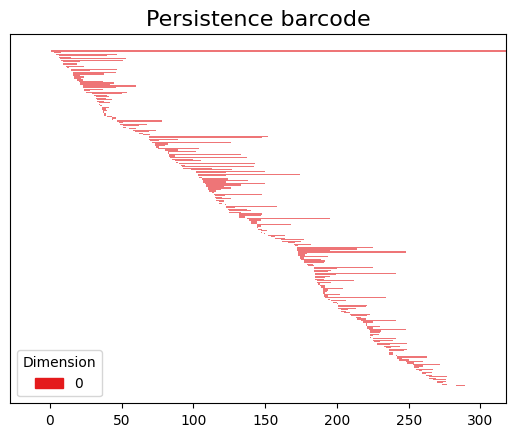

In [3]:
edges,node_heights = inputForGUDHI('m3p4_060407','pos',1)

st = gudhi.SimplexTree()

#adds vertices assigned to their height as the filtration value
for node,height in node_heights.items():
    st.insert([node],filtration=height)

#adds edges with the maximum height as filtration value
for u,v in edges:
    filt_value = max(node_heights[u],node_heights[v])
    st.insert([u,v],filtration=filt_value)

st.make_filtration_non_decreasing()

st.compute_persistence()
gudhi.plot_persistence_barcode(st.persistence())

# Alpha Complex

In [4]:
def nodesExtractor(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def nodesToArray(name):
    nodes_df = nodesExtractor(name)
    nodes_loc = nodes_df.loc[:,['X','Y','Z']]
    loc_array = nodes_loc.to_numpy()
    return loc_array

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

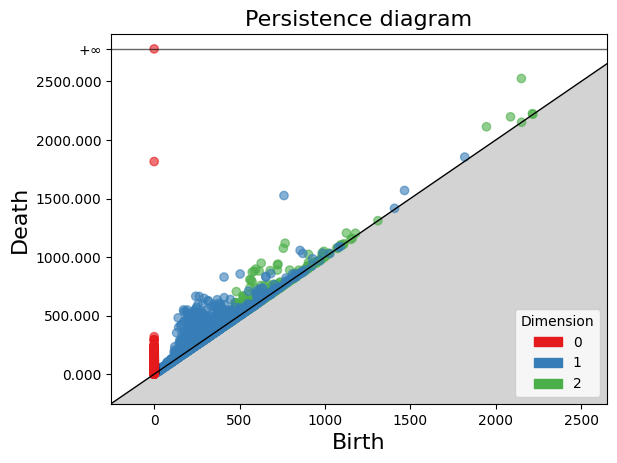

In [ ]:
# prints persistence diagram
point_loc = nodesToArray('m3p4_060407')

alpha_complex = gudhi.AlphaComplex(points = point_loc)

alpha_stree = alpha_complex.create_simplex_tree()

alpha_stree.compute_persistence()

gudhi.plot_persistence_diagram(alpha_stree.persistence())

Text(0.5, 1.0, 'Persistence Image')

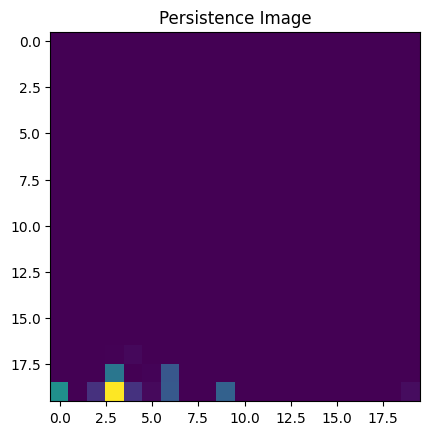

In [ ]:
## Print persistence image for dimension 1 and 2, can't do 0 right now because infinity
PI = gudhi.representations.PersistenceImage()
pi = PI.fit_transform([alpha_stree.persistence_intervals_in_dimension(2)])
plt.imshow(np.flip(np.reshape(pi[0],[20,20]),0))
plt.title('Persistence Image')

In [ ]:
## Lists every simplex
point_loc = nodesToArray('m3p4_060407')

alpha_complex = gudhi.AlphaComplex(points = point_loc)

alpha_stree = alpha_complex.create_simplex_tree()

alpha = alpha_stree.persistence()

for point in alpha:
    dim = point[0]
    bd = point[1]
    print("Dim: ",dim)
    print("(Birth, Death): ",bd)
    print()

Dim:  2
(Birth, Death):  (2150.5181636152374, 2525.7478440871473)

Dim:  2
(Birth, Death):  (766.8560023384189, 1118.4938364963025)

Dim:  2
(Birth, Death):  (626.7524190012209, 947.9418874571119)

Dim:  2
(Birth, Death):  (756.374553530713, 1075.7982594751343)

Dim:  2
(Birth, Death):  (594.9611380196766, 897.6473367719666)

Dim:  2
(Birth, Death):  (574.2987608478518, 871.5304745213659)

Dim:  2
(Birth, Death):  (585.8903544002015, 879.3995124851372)

Dim:  2
(Birth, Death):  (615.1013876454788, 881.1359421918316)

Dim:  2
(Birth, Death):  (560.2031375511599, 808.0455480623206)

Dim:  2
(Birth, Death):  (567.1500178212988, 803.6876999412558)

Dim:  2
(Birth, Death):  (481.1183952129022, 705.4113030663622)

Dim:  2
(Birth, Death):  (573.2529688664127, 791.5231534229513)

Dim:  2
(Birth, Death):  (725.4061076433629, 940.130499477115)

Dim:  2
(Birth, Death):  (721.9195373648536, 933.3809080070782)

Dim:  2
(Birth, Death):  (679.1583442257422, 884.8472078405233)

Dim:  2
(Birth, Death):

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

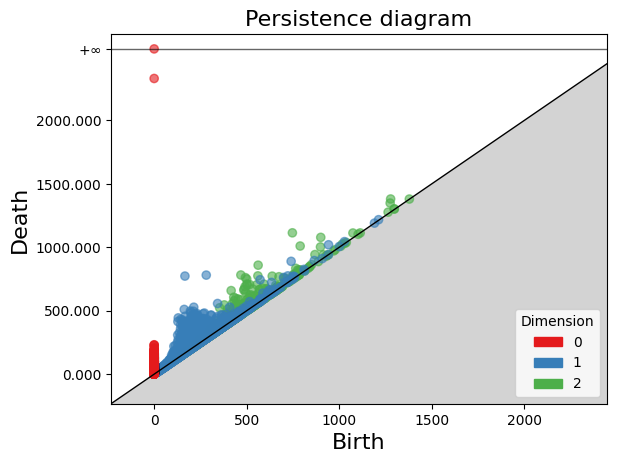

In [6]:
point_loc = nodesToArray('m2p4_053007')

alpha_complex = gudhi.AlphaComplex(points = point_loc)

alpha_stree = alpha_complex.create_simplex_tree()

alpha_stree.compute_persistence()

gudhi.plot_persistence_diagram(alpha_stree.persistence())